## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OrdinalEncoder

import lightgbm as lgb
from lightgbm import LGBMRegressor

Загрузим и изучим данные

In [2]:
data = pd.read_csv('/datasets/autos.csv')
display(data.head(5))
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Проверим датасет на пропуски и дубликаты

In [3]:
print(data.duplicated().sum())
print('')
print(data.isna().sum())

4

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


Удалим явные дубликаты

In [4]:
data = data.drop_duplicates()
print(data.duplicated().sum())

0


Заполним отсутствующие значения датафрейма по следующей логике:
1) записи с NaN в столбцах VehicleType , GearBox, FuelType, Repaired заполним значением "unknown", т.к. нет возмодности определить тип данных исходя из других данных (комбинации других столбцов)

2) модель определим по типу марки машины с одинаковой мощностью и типом кузова


In [5]:
data_clean = data.fillna({'VehicleType':'unknown','Gearbox':'unknown', 'Repaired':'unknown', 'FuelType':'unknown'})
print(data_clean.isna().sum())
data_clean.head(10)

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired                 0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,unknown,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,unknown,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [6]:
data_clean['Model'] = data_clean['Model'].fillna(data_clean.groupby(['Brand','VehicleType','Power'])['Model'].transform('first'))

In [7]:
data_clean.dropna()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,a5,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [8]:
print(data_clean.isna().sum())

DateCrawled             0
Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                3998
Kilometer               0
RegistrationMonth       0
FuelType                0
Brand                   0
Repaired                0
DateCreated             0
NumberOfPictures        0
PostalCode              0
LastSeen                0
dtype: int64


Проверим адекватность цифровых значений в датасете

In [9]:
data_clean = data_clean.drop(data_clean.query('Price == 0').index)
display(data_clean.query('RegistrationYear == 0')['RegistrationYear'].count())
data_clean = data_clean.drop(data_clean.query('Power == 0').index)
display(data_clean.query('Kilometer == 0')['Kilometer'].count())
data_clean = data_clean.drop('RegistrationMonth', axis=1)

0

0

Строки со значение 0 мы удаляем, т.к. эти признаки не информативны. Мы сразу заменили код проверки значений на ноль на код "удалить". В виду наличия пропусков в столбце месяц регистрации, мы удалили весь столбец, предполагая, что данный параметр не должен влиять на стоимость автомобиля. 

Проверим столбцы Цена, Пробег и Мощность на выбросы

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    307233.000000
mean       4809.878809
std        4586.543041
min           1.000000
25%        1300.000000
50%        3100.000000
75%        6950.000000
max       20000.000000
Name: Price, dtype: float64
Нижняя граница -15650.0 Верхняя граница 23900.0


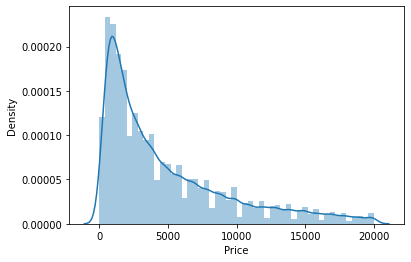

In [10]:
sns.distplot(data_clean['Price'].dropna())
print(data_clean['Price'].describe())
q1 = data_clean['Price'].quantile(0.25)
q3 = data_clean['Price'].quantile(0.75)
iqr = q3-q1
lower_bound = q1 - 3*iqr
upper_bound = q3 + 3*iqr
print('Нижняя граница',lower_bound,'Верхняя граница', upper_bound)

Все данные по ценам находятся в допустимых пределах. Исходя из порядка цен сложно понять их адекватность (не похоже на актуальные цены). Требуется экспертная оценка, но мы удалим цены ниже 100 евро. 

In [11]:
data_clean = data_clean.drop(data_clean.query('Price<100').index)
data_clean['Price'].describe()


count    305989.000000
mean       4829.328123
std        4585.681244
min         100.000000
25%        1350.000000
50%        3150.000000
75%        6950.000000
max       20000.000000
Name: Price, dtype: float64

count    305989.000000
mean        124.160035
std         194.849016
min           1.000000
25%          75.000000
50%         110.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64
Нижняя граница -150.0 Верхняя граница 375.0


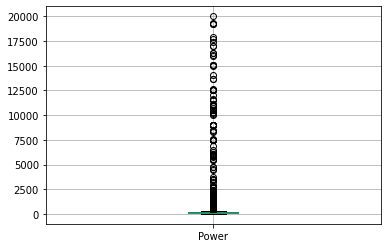

In [12]:
#sns.distplot(data_clean['Power'].dropna())
data_clean.boxplot(column='Power')
print(data_clean['Power'].describe())
q1 = data_clean['Power'].quantile(0.25)
q3 = data_clean['Power'].quantile(0.75)
iqr = q3-q1
lower_bound = q1 - 3*iqr
upper_bound = q3 + 3*iqr
print('Нижняя граница',lower_bound,'Верхняя граница', upper_bound)

Анализ доверительного интервала показывает нам, что все данные выборки находятся в норме. Однако Мощность 1, 2, 3 сложно назвать нормальной! Мы удалим все значения меньше 100 и больше 2000. Это нижняя и верхняя граница, согласно открытых источников. 

In [13]:
data_clean = data_clean.drop(data_clean.query('Power<100|Power>2000').index)
data_clean['Power'].describe()

count    195322.000000
mean        149.742922
std          62.992327
min         100.000000
25%         115.000000
50%         140.000000
75%         170.000000
max        2000.000000
Name: Power, dtype: float64

count    195322.000000
mean     131829.031036
std       34163.140513
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64
Нижняя граница 50000.0 Верхняя граница 225000.0


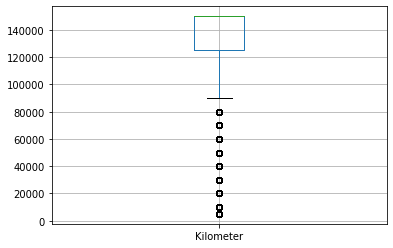

In [14]:
data_clean.boxplot(column='Kilometer')
#sns.distplot(data_clean['Power'].dropna())
print(data_clean['Kilometer'].describe())
q1 = data_clean['Kilometer'].quantile(0.25)
q3 = data_clean['Kilometer'].quantile(0.75)
iqr = q3-q1
lower_bound = q1 - 3*iqr
upper_bound = q3 + 3*iqr
print('Нижняя граница',lower_bound,'Верхняя граница', upper_bound)

Согласно анализа доверительного интервала есть значения, которые выходят за пределы нижней границы (50 000), однако, минимальныц пробег в 5000 это вполне вероятная ситуация. Данные оставляем.

Подготовим данные для обучения моделей. В обучающую выборку возбмем только столбцы, которые могут влиять на стоимость авто

In [16]:
data_clean['year_reg_web'] = pd.DatetimeIndex(data_clean['DateCreated']).year
    
for x in data_clean.query('year_reg_web < RegistrationYear').index:
    data_clean.loc[x,'RegistrationYear']= 2016

In [17]:
data_clean = data_clean.drop('year_reg_web', axis = 1)

In [18]:
features = data_clean.drop(['DateCrawled','Price', 'DateCreated','LastSeen'], axis=1)
target = data_clean['Price']

In [19]:
train_features_0, test_features, train_target_0, test_target = train_test_split(
                                features, target, test_size=0.2, random_state=12345)
train_features, valid_features, train_target, valid_target = train_test_split(
                                train_features_0, train_target_0, test_size=0.25, random_state=12345)

In [20]:
encoder = OrdinalEncoder(handle_unknown='ignore')
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired','RegistrationYear']

train_features_0[cat_columns] = encoder.fit_transform(train_features_0[cat_columns])
train_features[cat_columns] = encoder.transform(train_features[cat_columns])
#train_features_0[cat_columns] = encoder.transform(train_features_0[cat_columns])


#valid_features = pd.DataFrame(encoder.fit_transform(valid_features),
#columns=valid_features.columns)

test_features[cat_columns] = encoder.transform(test_features[cat_columns])

#features = pd.DataFrame(encoder.fit_transform(features),
#columns=features.columns)


/tmp/ipykernel_64/166633221.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features_0[cat_columns] = encoder.fit_transform(train_features_0[cat_columns])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_64/166633221.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

## Обучение моделей

In [21]:
from sklearn.metrics import make_scorer
RMSE = make_scorer((mean_squared_error))


Методом grid search найдем гиперпараменты для модели дерева решений

In [29]:
%%time

model = DecisionTreeRegressor(random_state=12345)
grid_tree = GridSearchCV(
    estimator=model,
    param_grid={
        'max_depth': np.arange(1, 11)
    },
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_tree.fit(train_features_0, train_target_0)

CPU times: user 12.8 s, sys: 24 ms, total: 12.8 s
Wall time: 12.8 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='neg_root_mean_squared_error')

In [30]:
results = pd.DataFrame(grid_tree.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.057701,0.004699,0.005052,0.001069,1,{'max_depth': 1},-3936.768405,-3922.309954,-3914.042387,-3904.903828,-3937.096869,-3923.024288,12.621206,10
1,0.097128,0.012466,0.004998,0.000711,2,{'max_depth': 2},-3592.410785,-3583.876124,-3580.166556,-3559.951720,-3590.782800,-3581.437597,11.635708,9
2,0.138272,0.005975,0.005182,0.000628,3,{'max_depth': 3},-3272.607450,-3241.864813,-3244.865784,-3224.902647,-3267.889500,-3250.426039,17.621816,8
3,0.204917,0.017727,0.005866,0.000750,4,{'max_depth': 4},-2930.943046,-2919.657452,-2903.487475,-2900.380836,-2921.746893,-2915.243141,11.552971,7
4,0.216315,0.005843,0.005272,0.000256,5,{'max_depth': 5},-2766.188891,-2754.482664,-2742.160263,-2737.099701,-2747.879790,-2749.562262,10.134998,6
5,0.255245,0.006122,0.005667,0.000359,6,{'max_depth': 6},-2622.149652,-2612.754582,-2593.229932,-2599.273564,-2596.614960,-2604.804538,10.915022,5
6,0.317216,0.042272,0.007390,0.001492,7,{'max_depth': 7},-2519.328045,-2519.754596,-2496.109936,-2498.436817,-2499.619293,-2506.649737,10.587194,4
7,0.327556,0.014270,0.006207,0.000042,8,{'max_depth': 8},-2432.703354,-2414.950638,-2408.274628,-2405.190913,-2386.643259,-2409.552558,14.903635,3
8,0.367276,0.015178,0.006620,0.000121,9,{'max_depth': 9},-2347.236259,-2337.294995,-2342.188634,-2336.796864,-2309.535781,-2334.610507,13.096306,2
9,0.416918,0.032304,0.008026,0.000714,10,{'max_depth': 10},-2287.642496,-2271.293082,-2279.988665,-2283.959479,-2254.414373,-2275.459619,11.844364,1


In [31]:
names = ['model','score','time_fit','time_predict'] 
best_model = pd.DataFrame(np.zeros((4,4)), columns=names)
best_model

,model,score,time_fit,time_predict
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0


In [32]:
best_model.loc[0, 'score'] = grid_tree.best_score_
best_model.loc[0, 'model'] = grid_tree.best_estimator_ 
best_model.loc[0, 'time_fit'] = results[results['rank_test_score'] == 1]['mean_fit_time'].values[0] 
best_model.loc[0, 'time_predict'] = results[results['rank_test_score'] == 1]['mean_score_time'].values[0]
best_model

,model,score,time_fit,time_predict
0,"DecisionTreeRegressor(max_depth=10, random_sta...",-2275.459619,0.416918,0.008026
1,0.0,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000


Методом grid search найдем гиперпараменты для модели леса решений

In [33]:
%%time

model = RandomForestRegressor(random_state=12345)
grid_forest = GridSearchCV(
    estimator=model,
    param_grid={
        'max_depth': np.arange(1, 6),
        'n_estimators': np.arange(1, 100, step=10),
    },
    scoring='neg_root_mean_squared_error',
    cv=5
)

grid_forest.fit(train_features_0, train_target_0)

CPU times: user 16min 21s, sys: 3.31 s, total: 16min 24s
Wall time: 16min 25s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
             scoring='neg_root_mean_squared_error')

In [34]:
results_1 = pd.DataFrame(grid_forest.cv_results_)

best_model.loc[1, 'score'] = grid_forest.best_score_
# best_model.loc[1, 'model'] = grid_forest.best_estimator_  # РУГАЕТСЯ на длинну значения?...
best_model.loc[1, 'time_fit'] = results_1[results_1['rank_test_score'] == 1]['mean_fit_time'].values[0] 
best_model.loc[1, 'time_predict'] = results_1[results_1['rank_test_score'] == 1]['mean_score_time'].values[0]
best_model

,model,score,time_fit,time_predict
0,"DecisionTreeRegressor(max_depth=10, random_sta...",-2275.459619,0.416918,0.008026
1,0.0,-2657.224135,12.590413,0.112925
2,0.0,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000


Методом grid search найдем гиперпараменты для модели логистической регрессии

In [35]:
%%time

model = LinearRegression()
grid_LinearRegression = GridSearchCV(
    estimator=model,
    param_grid={
        
    },
    scoring='neg_root_mean_squared_error',
    cv=5
)

grid_LinearRegression.fit(train_features_0, train_target_0)

CPU times: user 587 ms, sys: 741 ms, total: 1.33 s
Wall time: 1.29 s


GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={},
             scoring='neg_root_mean_squared_error')

In [36]:
results_2 = pd.DataFrame(grid_LinearRegression.cv_results_)

best_model.loc[2, 'score'] = grid_LinearRegression.best_score_
best_model.loc[2, 'model'] = grid_LinearRegression.best_estimator_ 
best_model.loc[2, 'time_fit'] = results_2[results_2['rank_test_score'] == 1]['mean_fit_time'].values[0] 
best_model.loc[2, 'time_predict'] = results_2[results_2['rank_test_score'] == 1]['mean_score_time'].values[0]
best_model

,model,score,time_fit,time_predict
0,"DecisionTreeRegressor(max_depth=10, random_sta...",-2275.459619,0.416918,0.008026
1,0.0,-2657.224135,12.590413,0.112925
2,LinearRegression(),-3389.532833,0.155633,0.071462
3,0.0,0.000000,0.000000,0.000000


Методом grid search найдем гиперпараменты для модели градиентного бустинга

In [37]:
%%time

model = LGBMRegressor(random_state=12345)
#gbm.fit(train_features,  train_target, eval_set=[(valid_features, valid_target)], eval_metric='rmse', verbose=10)

grid_boosting = GridSearchCV(
    estimator=model,
    param_grid={
        'max_depth': np.arange(1, 3),
        'n_estimators': np.arange(1, 51, step=10),
        #'num_leaves': [7, 14, 21, 28, 31, 50],
        #'learning_rate':
    },
    scoring='neg_root_mean_squared_error',
    cv=5
)

grid_boosting.fit(train_features_0, train_target_0)

CPU times: user 7min 13s, sys: 9.87 s, total: 7min 23s
Wall time: 7min 25s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=12345),
             param_grid={'max_depth': array([1, 2]),
                         'n_estimators': array([ 1, 11, 21, 31, 41])},
             scoring='neg_root_mean_squared_error')

In [38]:
results_3 = pd.DataFrame(grid_boosting.cv_results_)

best_model.loc[3, 'score'] = grid_boosting.best_score_
best_model.loc[3, 'model'] = grid_boosting.best_estimator_ 
best_model.loc[3, 'time_fit'] = results_3[results_3['rank_test_score'] == 1]['mean_fit_time'].values[0] 
best_model.loc[3, 'time_predict'] = results_3[results_3['rank_test_score'] == 1]['mean_score_time'].values[0]
best_model

,model,score,time_fit,time_predict
0,"DecisionTreeRegressor(max_depth=10, random_sta...",-2275.459619,0.416918,0.008026
1,0.0,-2657.224135,12.590413,0.112925
2,LinearRegression(),-3389.532833,0.155633,0.071462
3,"LGBMRegressor(max_depth=2, n_estimators=41, ra...",-2625.712771,19.577966,0.122383


## Анализ моделей

Протестируем выбранную модель на тестовых данных.

In [98]:
pred = grid_tree.predict(test_features)
RMSE = mean_squared_error(test_target, pred)**0.5
RMSE

2271.736403392562

In [27]:
from sklearn.dummy import DummyRegressor
dummy_clf = DummyRegressor()
dummy_clf.fit(train_features, train_target)
pred_dummy = dummy_clf.predict(test_features)

RMSE = mean_squared_error(test_target, pred_dummy)**0.5
RMSE

4942.966256909013